# Tarea 1 (Parte 2 de ML2)
# Juan Luis Baldelomar Cabrera

# Resumen

En el siguiente notebook se implementó diversos modelos de redes neuronales recurrentes (RNN) para llevar a cabo la clasificación de perfiles de twitter en función del género de la persona que administra el perfil. 

En los **ejercicios 2 y 3** se implementó una RNN simple y una RNN con un mecanismo de atención respectivamente para clasificar todos los tweets de un perfil. Al referirnos a todos los tweets es importante aclarar que se forma una gran cadena que contiene todos los tweets por usuario y esta gran cadena es la que reciben de entrada ambas RNN. 

Sabemos que las RNN no logran trabajar bien con grandes cadenas para procesar, incluso las que trabajan con mecanismos de atención, por ello se implementó otros dos modelos con RNNs (una simple y otra con atención) en donde ambas reciben como entrada tweet por tweet y clasifican tweet por tweet respecto al género del perfil que escribió cada tweet. Luego se tiene un sistema de votación simple en donde para cada perfil se decide su género en función de la mayoría de los tweets clasificados. Es decir si para cierto perfil la red clasifica que la mayoría de sus tweets provienen de una persona de género femenino, entonces el modelo clasifica al perfil como del género femenino. Se tiene la hipótesis de que estos modelo presentarán mejores resultados debido a que las cadenas a procesar son considerablemente más pequeñas. 

Por último, **en el ejercicio 4** se implemento una RNN con atención jerárquica. Naturalmente el primer nivel de atención se aplica a nivel de "palabras" (embeddings en realidad) y el segundo nivel de atención se aplica a nivel de tweets. De esta manera logramos codificar un perfil y la salida de este modelo nos indica el género de la persona que administra el perfil. 

En el **ejercicio 5** podemos ver la discusión de resultados y la visualización de la atención del modelo jerárquico.

Y finalmente en el **ejercicio 6** responderemos unas preguntas

# ATENCIÓN: EJECUTAR LA INSTRUCCIÓN DE ABAJO ÚNICAMENTE SI DESEA GUARDAR LOS ESTADOS DE LOS MODELOS EN SU DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerías y Archivos

In [ ]:
import pandas as pd
import pickle
import numpy as np
import nltk
import re
nltk.download('punkt')
from tqdm.auto import tqdm
import copy

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import torch.nn.functional as F

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from google_drive_downloader import GoogleDriveDownloader as gdd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<h2>Archivos que contienen word2vec, datasets, y pesos de modelos Entrenados</h2>

In [ ]:
gdd.download_file_from_google_drive(file_id   = '1p-2CAagdNmbGJq3VUrdnzTJGu_JoZ3E1',
                                    dest_path = 'data/word2vec_col.txt',
)

gdd.download_file_from_google_drive(file_id   = '1bofImIEUN_j1pE32Tuj_F4Pdgrm9DwsP',
                                    dest_path = 'data/author_prof.zip',
                                    unzip = True,
)

# Simple Model Weights
gdd.download_file_from_google_drive(file_id   = '1-4YmyE8-VkghQXQQhf2Um3bPy9bt5M11',
                                    dest_path = 'data/SimpleGRU.pkl',
)

# ATTN Model Weights
gdd.download_file_from_google_drive(file_id   = '1-8WK4IcIG1oyC8m24YOu9sRrVOgYA4J5',
                                    dest_path = 'data/AttnGRU.pkl',
)

# Simple Model Tweet by Tweet Weights
gdd.download_file_from_google_drive(file_id   = '1-9-lANOfCRVRFHpv-pEdptqo0AwDGc4s',
                                    dest_path = 'data/TbyT_SimpleGRU.pkl',
)

# ATTN Model Tweet by Tweet Weights
gdd.download_file_from_google_drive(file_id   = '1-CzmP5jGQS9C8siMc4ltTT15egM6BRkj',
                                    dest_path = 'data/TbyT_AttnGRU.pkl',
)

# Hierarchical Model Weights
gdd.download_file_from_google_drive(file_id   = '1-0UFYFVid-SKiQyckwG8du6nuHhD6gAj',
                                    dest_path = 'data/HierGRU.pkl',
)

Unzipping...Done.


<h2>  Utilities to Store and Load Models Weights</h2>

In [ ]:
import pickle
# -------------------------------------------------- READ/WRITE PKL FILES ------------------------------------------------------------

# store processed data in pkl files
def save_pkl_data(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
        print("data stored succesfully to: ", filename)


# read processed data in pkl files
def load_pkl_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# Ejercicio 1

El siguiente bloque de código contiene las funciones principales para procesar los datasets. Los datasets contienen la información almacenada en archivos XML. Las funciones se encargan de procesar estos archivos XML y devolver la información en diccionarios de python con la estructura adecuada para cada modelo.

In [ ]:
import xml.etree.ElementTree as ET
import os

# get labels stored in the file with name: filename for each sample in the dataset
def get_labels(filename):
    file = open(filename)
    labels = {}
    for line in file.readlines():
        fields = line.split(':::')
        labels[fields[0]] = 1 if fields[1] == 'male' else 0

    return labels

# for a profile get all tweets as a big string (Models in Sections 'Ejercicio 2' y 'Ejercicio 3')
def get_all_tweets_as_big_string(filename, labels):
    filename_no_dir = filename.split('/')[-1]
    name, extenstion = (field for field in filename_no_dir.split('.'))
    tree = ET.parse(filename)
    root = tree.getroot()
    documents = root[0]
    text = ""
    for doc in documents:
        text += doc.text + " "

    return {'author_id': name, 'text': text, 'target': labels[name]}

# get list of tweets by author (author id = filename without xml extension) (Models in Sections 'Ejercicio 2 Extra', 'Ejercicio 3 Extra')
def get_tweets_as_list_by_author(filename, labels):
    filename_no_dir = filename.split('/')[-1]
    name, extenstion = (field for field in filename_no_dir.split('.'))
    tree = ET.parse(filename)
    root = tree.getroot()
    documents = root[0]
    author_tweets = []
    for doc in documents:
        author_tweets.append({'author_id':name, 'text': doc.text, 'target': labels[name]})

    return author_tweets

# get tweets as a document in a python dictionary (Model in Section 'Ejercicio 4')
def get_tweets_as_document_by_author(filename, labels):
    filename_no_dir = filename.split('/')[-1]
    name, extenstion = (field for field in filename_no_dir.split('.'))
    tree = ET.parse(filename)
    root = tree.getroot()
    documents = root[0]
    author_tweets = []
    for doc in documents:
        author_tweets.append(doc.text)

    return {'author_id': name, 'tweets': author_tweets, 'target': labels[name]}

# get filenames in a directory and labels in the labels file
def get_files_and_labels(split):

    # choose the train or test directory
    if split == 'train':
      directory = 'data/author_profiling_pan/es_train'
    else:
      directory = 'data/author_profiling_pan/es_test'
    
    # list all files 
    files_in_dir = os.listdir(directory)
    filenames = []
    
    # retrieve all xml files
    for filename in files_in_dir:
      if filename.endswith('.xml'):
        filenames.append(directory + '/' + filename)
    
    # get labels and all the tweets processing the xml files
    labels = get_labels(directory + '/' + 'truth.txt')
    
    return filenames, labels


# ############################################################################# CORE FUNCTIONS TO LOAD DATA AND LABELS FROM FILES ############################################################################# 

# The next couple of functions are the ones that are used to load and pass the data to the Dataset constructor.

# load data joining all tweets by user into a big string 
def load_data(split):
    '''Método para cargar datos.
        El texto está en la columna "text" y las categorías en la columna "target".
    '''

    # get files to be processed and labels
    filenames, labels = get_files_and_labels(split)

    # get all tweets as a big string
    all_tweets = [get_all_tweets_as_big_string(filename, labels) for filename in filenames] 

    
    # perform a split of the train data into train and validation if necessary
    if split == 'train':
      
      # get random index for validation data
      val_index = np.random.choice(len(all_tweets), size= int(0.2 * len(all_tweets)), replace=False)
      
      # get the remaining indexes for train data
      train_index = [i for i in range(len(all_tweets))]
      for n in val_index:
        train_index.remove(n)

      # return train and validation data          
      return [all_tweets[i] for i in train_index], [all_tweets[i] for i in val_index]

    # return test data  
    return all_tweets


# load data tweet by tweet
def load_data_by_author(split):

    # get files to be processed and labels
    filenames, labels = get_files_and_labels(split)

    # get all tweets in a list by author
    authors = [get_tweets_as_list_by_author(filename, labels) for filename in filenames]

    # list to contain all tweets
    all_tweets = []

    # append all tweets by author into a single list
    for author_tweets in authors:
        all_tweets += author_tweets
        
    # perform a split of the train data into train and validation if necessary
    if split == 'train':

      # get random index for validation data
      val_index = np.random.choice(len(all_tweets), size= int(0.2 * len(all_tweets)), replace=False)

      # get the remaining indexes for train data (we use a dictionary to mark with a flag the unavailable indexes because 
      #                                           there is so much data and removing them from a list is too slow)
      train_index_dict = {}
      train_index = []

      # initialize dict
      for i in range(len(all_tweets)):
          train_index_dict[i] = 0

      # mark unavailable indexes
      for i in val_index:
          train_index_dict[i] = 1

      # get available indexes for train data
      for i in range(len(all_tweets)):
          if train_index_dict[i] == 0:
              train_index.append(i)
      
      # return train and validation data
      return [all_tweets[i] for i in train_index], [all_tweets[i] for i in val_index]

    # return test data  
    return all_tweets


# Ejercicio 1 (Dataset Class)

Las funciones de arriba se encargan de procesar los archivos para obtener la información. La clase implementada abajo se encarga de obtener esta información y aplicar el preprocesamiento necesario para obtener las entradas (o batch de entradas) que se darán a los modelos de RNN. 

Para preprocesar la información hacemos lo siguiente: 


1.   pasamos el texto a minúsculas debido a que la tabla de word2vec utilizada  contiene todas las palabras en minúsculas.

2.   Los links o ligas a otras páginas de internet son transformadas únicamente al token "http". Esto se hace porque el token http si existe en la tabla word2vec utilizada, sin embargo los links como tal no, entonces transformamos todo el link al token http para ver si la red puede aprender algo importante para la tarea en función de la cantidad de links que publica una persona.

3. Los nombres de usuarios son transformados todos a la forma "@usuario". De igual manera, tanto el token "@" como el token "usuario" son reconocidos por la tabla word2vec, entonces con el objetivo de que esto simplifique el contexto o información que la red procesa. 

 

In [ ]:
class gender_dataset(Dataset):
    def __init__(self, split):
        super(Dataset, self).__init__()
        self.load_data(split)
        self.vocab, self.emb_mat = self.load_vocab_embeddings()
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        '''Método principal para cargar una observación del dataset.
           label: categoría a la que pertenece la observación.
           word_ids: lista de índices de las palbras en el vocabulario.
        '''
        label = self.data[index]['target']
        author = self.data[index]['author_id']
        words, word_ids = self.preprocessed_text(index)
        return word_ids, label, words, author
        
    def preprocessed_text(self, index):
        '''Preprocess text and '''

        # remove links, usernames and lower the text
        text = self.data[index]['text']
        text = re.sub(r"http\S+", "http", text)
        text = re.sub(r"@([a-z]|[A-Z]|[0-9]|_)+", "@usuario", text)
        text = text.lower()
        words = nltk.word_tokenize(text)
        word_ids = [self.vocab[word] if word in self.vocab.keys() else self.emb_mat.shape[0]-1\
                        for word in words]
        return words, word_ids

    def load_data(self, data):
        '''Método para cargar datos.
        '''  
        self.data = data

    def load_vocab_embeddings(self):
        '''Embeddings preentrenados en twitter.
           emb_mat: Matriz de embeddings. Un vector de tamaño 200 para cada palabra del vocabulario.
           vocab: Diccionario, asigna a cada palabra su renglón correspondiente en la matriz de embeddings.
        '''
        embeddings_list = []
        self.vocab_dict = {}
        vocab = {}
        with open('data/word2vec_col.txt', 'r') as f:
            for i, line in enumerate(f):
                if i!=0:
                    values = line.split()
                    self.vocab_dict[i+1] = values[0]
                    vocab[values[0]] = i+1
                    vector = np.asarray(values[1:], "float32")
                    embeddings_list.append(vector)
        embeddings_list.insert(0,np.mean(np.vstack(embeddings_list), axis=0))
        embeddings_list.insert(0,np.zeros(100))
        self.vocab_dict[0] = '[PAD]'
        self.vocab_dict[1] = '[UNK]'
        vocab['[PAD]'] = 0
        vocab['[UNK]'] = 1
        emb_mat = np.vstack(embeddings_list)

        return vocab, emb_mat

    def get_weights(self):
        '''Devuelve pesos inversos para cada categoría. Mayor peso para la categoría con menos observaciones.'''
        cat_1 = 0
        for d in self.data:
          cat_1 += d['target']

        cat_0 = len(self.data) - cat_1
        maxi = max(cat_0, cat_1)
        return torch.tensor([maxi/cat_0, maxi/cat_1])

    def collate_fn(self, batch):
        '''Función que ejecuta el dataloader para formar batches de datos.'''

        zipped_batch = list(zip(*batch))
        word_ids = [torch.tensor(t) for t in zipped_batch[0]]
        word_ids = torch.cat(word_ids, dim=0)
        lengths = torch.tensor([len(t) for t in zipped_batch[0]])
        labels = torch.tensor(zipped_batch[1])
        words = zipped_batch[2]
        authors = zipped_batch[3]
        return word_ids, lengths, labels, words, authors

# Ejercicio 2 (Modelo 1: GRU Simple)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
                 bidirectional=False, emb_mat=None, dense_hidden_size=256):
        '''Constructor, aquí definimos las capas.
        input:
            input_size: Tamaño de los embeddings de las palabras.
            hidden_size: Tamaño de la capa oculta de la GRU.
            num_layers: Número de capas de la GRU.
            bidirectional: True si se quiere una GRu bidireccional.
            emb_mat: Matriz de embeddings del vocabulario.
            dense_hidden_size: Tamaño de la capa ocula del clasificador.
        '''
        super(SimpleRNN, self).__init__()
        # Matriz entrenable de embeddings, tamaño vocab_size x 100
        self.embeddings = nn.Embedding.from_pretrained(\
                            torch.FloatTensor(emb_mat), freeze=False)
        # Gated Recurrent Unit
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=num_layers, bidirectional=bidirectional)
        # Número de direcciones de la GRU
        directions = 2 if bidirectional else 1
        # Clasificador MLP
        self.classifier = nn.Sequential(\
                            nn.Linear(hidden_size*directions, dense_hidden_size),
                            nn.BatchNorm1d(dense_hidden_size),
                            nn.ReLU(),
                            nn.Linear(dense_hidden_size, 2))
    
    def forward(self, input_seq, lengths):
        '''Función feed-forward de la red.
        input:
            input_seq: Lista de ids para cada palabra.
            lengths: Número de palabras en cada una de las observaciones del batch.
        output:
            x: vectores para clasificar.
            return None for consistency with the next model
        '''
        # Calcula el embedding para cada palabra.
        x = self.embeddings(input_seq)
        # Forma las secuencias de palabras que entraran a la GRU.
        x = x.split(lengths.tolist())
        # Añade pading y empaqueta las secuencias (mayor velocidad de cómputo).
        x = pad_sequence(x)
        x = pack_padded_sequence(x, lengths, enforce_sorted=False)

        # remember output contains the hidden state of all the recurrent steps, hn is the hidden state in last step 
        output, hn = self.gru(x)
        hn = torch.cat([h for h in hn], dim=-1)
        x = self.classifier(hn)
        return x, None

<h2> Función para Evaluar los modelos y Funciones auxiliares</h2>

Se puede observar que la función eval_model recibe un parámetro mode, este indica si la función se esta utilizando para un esquema de votación o no. 

In [ ]:
def count_prediction(authors, predictions, accumulator):
  
    for author, pred in zip(authors, predictions):
      if accumulator.get(author) == None:
        accumulator[author] = 0

      accumulator[author] += -1 if pred == 0 else 1
    
def vote(labels, accumulator):
    keys = accumulator.keys() 
    targets = [labels[k] for k in keys]
    preds = [1 if accumulator[k] >= 0 else 0 for k in keys]
    
    return targets, preds

def eval_model(model, dataloader, criterion, device, use_acc=False, mode='non_vote', all_labels = None):
    '''Función para evaluar el modelo.'''
    accumulator = {}

    with torch.no_grad():
        model.eval()
        losses = []
        preds = torch.empty(0).long()
        targets = torch.empty(0).long()
        scores_list = []
        words_list = []
        pred_list = []

        for data in tqdm(dataloader):
            torch.cuda.empty_cache()
            seq, seq_len, labels, words, authors = data
            seq, labels = seq.to(device), labels.to(device)
            output, scores = model(seq, seq_len)
            output = F.log_softmax(output, dim=1)
            loss = criterion(output, labels)
            losses.append(loss.item())
            predictions = F.log_softmax(output, dim=1).argmax(1)

            preds = torch.cat([preds, predictions.cpu()], dim=0)
            targets = torch.cat([targets, labels.cpu()], dim=0)

            if mode=='vote':
              count_prediction(authors, predictions.tolist(), accumulator)
              

            if scores is not None:
                pred_list += predictions.tolist()
                scores = scores.cpu().squeeze(2).tolist()
                scores_list += scores
                words_list += words

        model.train()
        preds = preds.numpy()
        targets = targets.numpy()
        metric = accuracy_score(targets, preds) if use_acc else f1_score(targets, preds, average='binary')

        if mode == 'vote':
          targets_by_author, preds_by_author = vote(all_labels, accumulator)
          metric_by_vote = accuracy_score(targets_by_author, preds_by_author) if use_acc else f1_score(targets_by_author, preds_by_author, average='binary') 
          metric_str = 'accuracy by votation: ' if use_acc else 'f1 score by votation: ' 
          print(metric_str, metric_by_vote)

        return np.mean(losses), metric, scores_list, words_list, pred_list

<h2> Entrenar y Evaluar el modelo</h2>

**Creamos los datasets**

In [ ]:
# load data by all users
train_data, val_data = load_data('train')
test_data = load_data('test')

In [ ]:
train_dataset = gender_dataset(train_data)
val_dataset = gender_dataset(val_data)
test_dataset = gender_dataset(test_data)

**Creamos los Dataloaders que formarn los Batch**

In [ ]:
batch_size=128

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn = train_dataset.collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn = val_dataset.collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn = test_dataset.collate_fn, shuffle=False)

**Creamos el modelo y el optimizador a utilizar**

In [ ]:
lr = 0.001
epochs = 10
weight_decay=0.0001
beta1=0
beta2=0.999
device = torch.device('cuda')

In [ ]:
model = SimpleRNN(emb_mat=train_dataset.emb_mat, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

**Cargamos el Modelo del archivo correspondiente de pesos descargado al inicio** (Omitir este paso si se desea entrenar desde 0) 

In [ ]:
best_state_dict = load_pkl_data('data/SimpleGRU.pkl')
model.load_state_dict(best_state_dict, )

<All keys matched successfully>

**Entrenamos el modelo**

In [ ]:
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_dataloader):
        # Limpia basura de la memoria GPU
        torch.cuda.empty_cache()
        # Reiniciamos el cálculo del gradiente
        optimizer.zero_grad()
        # Desempaca los datos que salen del dataloader
        seq, seq_len, labels, _, _ = data
        # Mueve los datos al mismo device en el que este el modelo
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        # Calcula el gradiente de la pérdida
        loss.backward()
        # Realiza un paso de la optimización
        optimizer.step()
    
    #Evalúa los modelos en los conjuntos de entrenamiento y valuación
    #train_loss, train_f1, _, _, _ = eval_model(model, train_dataloader, criterion, device, use_acc=True)
    val_loss, val_f1, _, _, _ = eval_model(model, val_dataloader, criterion, device, use_acc=True)
    print('epoch: %d'%(epoch))
    print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
    if val_f1>best_val_f1:
        best_val_f1=val_f1
        best_state_dict=copy.deepcopy(model.state_dict())

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0
val_loss: 0.693043 | val_acc: 0.548810


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1
val_loss: 0.714383 | val_acc: 0.539286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2
val_loss: 0.947233 | val_acc: 0.528571


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 3
val_loss: 0.849266 | val_acc: 0.536905


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 4
val_loss: 0.946539 | val_acc: 0.559524


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 5
val_loss: 0.960542 | val_acc: 0.526190


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 6
val_loss: 1.260313 | val_acc: 0.525000


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 7
val_loss: 1.340668 | val_acc: 0.526190


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 8
val_loss: 1.387781 | val_acc: 0.534524


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 9
val_loss: 1.526193 | val_acc: 0.505952


<h2>Ejecutar únicamente si desea guardar los pesos en su drive</h2>

In [ ]:
#save_pkl_data(best_state_dict, 'drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/SimpleGRU.pkl')

data stored succesfully to:  drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/SimpleGRU.pkl


**Evaluamos el Modelo**

In [ ]:
model.load_state_dict(best_state_dict)
train_loss, train_f1, _, _, _ = eval_model(model, train_dataloader, criterion, device, use_acc=True)
val_loss, val_f1, _, _, _ = eval_model(model, val_dataloader, criterion, device, use_acc=True)
test_loss, test_f1, _, _, _ = eval_model(model, test_dataloader, criterion, device, use_acc=True)
print('train_loss: %5f | train_acc: %5f'%(train_loss, train_f1)) 
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_f1)) 

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss: 0.444778 | train_acc: 0.788095
val_loss: 0.946539 | val_acc: 0.559524
test_loss: 0.920548 | test_acc: 0.560000


# Ejercicio 3 (Modelo 2: GRU con atención)

In [ ]:
class AttnModule(nn.Module):
    def __init__(self, input_size, attn_hidden_size=128):
        '''
        input:
            input_size: tamaño de la capa oculta de la GRU.
            attn_hidden_size: tamaño de la capa oculta.
        '''
        super(AttnModule, self).__init__()
        self.fc1 = nn.Linear(input_size, attn_hidden_size)
        self.fc2 = nn.Linear(attn_hidden_size, 1, bias=False)

    def forward(self, seq, lengths):
        '''
        input:
            seq: secuencia de vectores ocultos de la GRU.
            lengths: número de palabras en cada observación.
        '''
        # unpack hidden states from the GRU
        x = pad_packed_sequence(seq)[0]
        seq_len, batch_size, nhid = x.size()

        # linearize the access to all the hidden states of each batch and compute  their output with tanh as activation function
        u = self.fc1(x.view(batch_size*seq_len, nhid))
        u = torch.tanh(u)

        # u^t * h_i (dot product with the u query vector) to get the score
        scores = self.fc2(u)

        # get back the scores into their original shape before being linearized in the output calculation
        scores = scores.view(seq_len, batch_size, 1)

        
        # Assign -100 to positions with padding to avoid them being considered through the softmax function.
        # this is also needed due to the way output is computed with fc1 and the bias of this layer could modify the padding values 
        # NOTE: remember that pack_padded_sequence and pad_packed_sequence are inverse operations
        scores = nn.utils.rnn.pack_padded_sequence(scores, lengths=lengths,enforce_sorted=False)
        scores = nn.utils.rnn.pad_packed_sequence(scores, padding_value=-100)[0]
        
        # softmaxt to the scores in dim = 0 because the Batch is in dim = 1, and the sequence is along dim = 0
        scores = F.softmax(scores, dim=0)

        # transpose scores and X to put Batch Dimension first. 
        # Then transpose dimension 1 and 2 of x to have hidden states from the GRU in columns instead of rows
        scores = scores.transpose(0,1)
        x = x.transpose(0,1).transpose(1,2)

        # for each batch multiply the hidden states by their scores and sum them (a matrix multiplication x * scores does this)
        x = torch.bmm(x, scores)
        return x.squeeze(2), scores

In [ ]:
class AttnRNN(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
                 bidirectional=False, emb_mat=None, dense_hidden_size=256,
                 attn_hidden_size=128):
        super(AttnRNN, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(\
                            torch.FloatTensor(emb_mat), freeze=False)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=num_layers, bidirectional=bidirectional)
        directions = 2 if bidirectional else 1
        self.attn = AttnModule(input_size=hidden_size*directions)
        self.classifier = nn.Sequential(\
                            nn.Linear(hidden_size*directions, dense_hidden_size),
                            nn.BatchNorm1d(dense_hidden_size),
                            nn.ReLU(),
                            nn.Linear(dense_hidden_size, 2))
        
    def forward(self, input_seq, lengths):
        x = self.embeddings(input_seq)
        x = x.split(lengths.tolist())
        x = pad_sequence(x)
        x = pack_padded_sequence(x, lengths, enforce_sorted=False)
        output, hn = self.gru(x)
        x, scores = self.attn(output, lengths)
        x = self.classifier(x)
        return x, scores.detach()

**Construimos el Modelo y el Optimizador a Utilizar**

In [ ]:
lr = 0.0001
epochs = 10
device = torch.device('cuda')
weight_decay=0.0001
beta1=0
beta2=0.999

In [ ]:
model = AttnRNN(emb_mat=train_dataset.emb_mat, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

**Cargamos el Modelo del archivo correspondiente de pesos descargado al inicio** (Omitir este paso si se desea entrenar desde 0) 

In [ ]:
best_state_dict = load_pkl_data('data/AttnGRU.pkl')
model.load_state_dict(best_state_dict, )

<All keys matched successfully>

**Entrenamos el Modelo**

In [ ]:
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_dataloader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, labels, _, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    train_loss, train_f1, _, _, _ = eval_model(model, train_dataloader, criterion, device, use_acc=True)
    val_loss, val_f1, _, _, _ = eval_model(model, val_dataloader, criterion, device, use_acc=True)
    print('epoch: %d'%(epoch))
    print('train_loss: %5f | val_loss: %5f | train_acc: %5f | val_acc: %5f'%(train_loss, val_loss, train_f1, val_f1)) 
    if val_f1>best_val_f1:
        best_val_f1=val_f1
        best_state_dict=copy.deepcopy(model.state_dict())

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.669531 | val_loss: 0.667203 | train_acc: 0.661905 | val_acc: 0.665476


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.602325 | val_loss: 0.596729 | train_acc: 0.709524 | val_acc: 0.713095


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.566489 | val_loss: 0.558608 | train_acc: 0.714881 | val_acc: 0.726190


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.531607 | val_loss: 0.538082 | train_acc: 0.751190 | val_acc: 0.738095


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.515917 | val_loss: 0.528347 | train_acc: 0.765179 | val_acc: 0.750000


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.506529 | val_loss: 0.519818 | train_acc: 0.767857 | val_acc: 0.757143


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.500750 | val_loss: 0.524228 | train_acc: 0.759524 | val_acc: 0.734524


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.484776 | val_loss: 0.517811 | train_acc: 0.775893 | val_acc: 0.746429


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.510121 | val_loss: 0.534833 | train_acc: 0.741667 | val_acc: 0.732143


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.478790 | val_loss: 0.502736 | train_acc: 0.781845 | val_acc: 0.772619


**DESCOMENTAR SOLO SI DESEA GUARDAR LOS PESOS EN EL DRIVE MONTADO**

In [ ]:
#save_pkl_data(best_state_dict, 'drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/AttnGRU.pkl')

data stored succesfully to:  drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/AttnGRU.pkl


**Evaluamos el Modelo** 

In [ ]:
model.load_state_dict(best_state_dict)
train_loss, train_f1, train_scores, train_words, train_pred = eval_model(model, train_dataloader, criterion, device, use_acc=True)
val_loss, val_f1, val_scores, val_words, val_pred = eval_model(model, val_dataloader, criterion, device, use_acc=True)
test_loss, test_f1, test_scores, test_words, test_pred = eval_model(model, test_dataloader, criterion, device, use_acc=True)
print('train_loss: %5f | train_acc: %5f'%(train_loss, train_f1)) 
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_f1)) 

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss: 0.484555 | train_acc: 0.781845
val_loss: 0.502736 | val_acc: 0.772619
test_loss: 0.523513 | test_acc: 0.755000


# Ejercicio 2 Extra (Modelo 3 : RNN Simple Procesando Tweet por Tweet)

**Cargamos el Dataset, construimos Dataloader, Construimos Modelo y Optimizador**

In [ ]:
train_data, val_data = load_data_by_author('train')
test_data = load_data_by_author('test')

In [ ]:
train_dataset = gender_dataset(train_data)
val_dataset = gender_dataset(val_data)
test_dataset = gender_dataset(test_data)

In [ ]:
batch_size = 256

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn = train_dataset.collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn = val_dataset.collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn = test_dataset.collate_fn, shuffle=False)

In [ ]:
lr = 0.0001
epochs = 10
device = torch.device('cuda')
weight_decay=0.0001
beta1=0
beta2=0.999

In [ ]:
model = SimpleRNN(emb_mat=train_dataset.emb_mat, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

**Cargamos el Modelo del archivo correspondiente de pesos descargado al inicio** (Omitir este paso si se desea entrenar desde 0) 

In [ ]:
best_state_dict = load_pkl_data('data/TbyT_SimpleGRU.pkl')
model.load_state_dict(best_state_dict, )

<All keys matched successfully>

**Entrenamos el Modelo**

In [ ]:
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_dataloader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, labels, _, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    #train_loss, train_f1, _, _, _ = eval_model(model, train_dataloader, criterion, device)
    val_loss, val_f1, _, _, _ = eval_model(model, val_dataloader, criterion, device, use_acc=True)
    print('epoch: %d'%(epoch))
    print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
    if val_f1>best_val_f1:
        best_val_f1=val_f1
        best_state_dict=copy.deepcopy(model.state_dict())

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 0
val_loss: 0.657268 | val_acc: 0.605769


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 1
val_loss: 0.649337 | val_acc: 0.616305


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 2
val_loss: 0.645483 | val_acc: 0.622079


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 3
val_loss: 0.644813 | val_acc: 0.623150


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 4
val_loss: 0.644700 | val_acc: 0.625615


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 5
val_loss: 0.643828 | val_acc: 0.626519


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 6
val_loss: 0.644790 | val_acc: 0.625781


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 7
val_loss: 0.644269 | val_acc: 0.621769


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 8
val_loss: 0.644477 | val_acc: 0.625698


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 9
val_loss: 0.645362 | val_acc: 0.622996


**DESCOMENTAR SOLO SI DESEA GUARDAR LOS PESOS EN EL DRIVE MONTADO**

In [ ]:
#save_pkl_data(best_state_dict, 'drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/TbyT_SimpleGRU.pkl')

data stored succesfully to:  drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/TbyT_SimpleGRU.pkl


**Evaluamos el Modelo**

Es importante resaltar que ahora tenemos una métrica extra, y es el F1 score de las predicciones realizadas por el esquema de votación

In [ ]:
model.load_state_dict(best_state_dict)
test_labels = get_labels('data/author_profiling_pan/es_test/truth.txt')
train_labels = get_labels('data/author_profiling_pan/es_train/truth.txt')

loss, f1, scores, words, pred = eval_model(model, train_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=train_labels)
print('train_loss: %5f | train_acc: %5f'%(loss, f1)) 

loss, f1, scores, words, pred = eval_model(model, val_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=train_labels)
print('val_loss: %5f | val_acc: %5f'%(loss, f1)) 

test_loss, test_f1, test_scores, test_words, test_pred = eval_model(model, test_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=test_labels)
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_f1)) 

  0%|          | 0/1313 [00:00<?, ?it/s]

accuracy by votation:  0.7407142857142858
train_loss: 0.628467 | train_acc: 0.643189


  0%|          | 0/329 [00:00<?, ?it/s]

accuracy by votation:  0.7266666666666667
val_loss: 0.627368 | val_acc: 0.643389


  0%|          | 0/1094 [00:00<?, ?it/s]

accuracy by votation:  0.7085714285714285
test_loss: 0.651251 | test_acc: 0.619796


# Ejercicio 3 Extra (Modelo 4: RNN con Atención Tweet por Tweet)

In [ ]:
lr = 0.0001
epochs = 10
device = torch.device('cuda')
weight_decay=0.0001
beta1=0
beta2=0.999

In [ ]:
model = AttnRNN(emb_mat=train_dataset.emb_mat, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

**Cargamos el Modelo del archivo correspondiente de pesos descargado al inicio** (Omitir este paso si se desea entrenar desde 0) 

In [ ]:
best_state_dict = load_pkl_data('data/TbyT_AttnGRU.pkl')
model.load_state_dict(best_state_dict, )

<All keys matched successfully>

**Entrenamos Modelo**

In [ ]:
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_dataloader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, labels, _, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    #train_loss, train_f1, _, _, _ = eval_model(model, train_dataloader, criterion, device)
    val_loss, val_f1, _, _, _ = eval_model(model, val_dataloader, criterion, device, use_acc=True)
    print('epoch: %d'%(epoch))
    print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
    if val_f1>best_val_f1:
        best_val_f1=val_f1
        best_state_dict=copy.deepcopy(model.state_dict())

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 0
val_loss: 0.651381 | val_acc: 0.616686


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 1
val_loss: 0.646364 | val_acc: 0.622341


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 2
val_loss: 0.643928 | val_acc: 0.625317


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 3
val_loss: 0.642652 | val_acc: 0.625876


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 4
val_loss: 0.640793 | val_acc: 0.629400


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 5
val_loss: 0.639461 | val_acc: 0.630162


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 6
val_loss: 0.640200 | val_acc: 0.630138


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 7
val_loss: 0.642575 | val_acc: 0.630127


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 8
val_loss: 0.641298 | val_acc: 0.627888


  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

epoch: 9
val_loss: 0.640315 | val_acc: 0.629817


**DESCOMENTAR SOLO SI DESEA GUARDAR LOS PESOS EN EL DRIVE MONTADO**

In [ ]:
#save_pkl_data(best_state_dict, 'drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/TbyT_AttnGRU.pkl')

data stored succesfully to:  drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/TbyT_AttnGRU.pkl


**Evaluación de Modelo**

De igual manera aquí también tenemos la métrica extra obtenida por el esquema de votación.

In [ ]:
model.load_state_dict(best_state_dict)
test_labels = get_labels('data/author_profiling_pan/es_test/truth.txt')
train_labels = get_labels('data/author_profiling_pan/es_train/truth.txt')

loss, f1, scores, words, pred = eval_model(model, train_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=train_labels)
print('train_loss: %5f | train_acc: %5f'%(loss, f1)) 

loss, f1, scores, words, pred = eval_model(model, val_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=train_labels)
print('val_loss: %5f | val_acc: %5f'%(loss, f1)) 

test_loss, test_f1, test_scores, test_words, test_pred = eval_model(model, test_dataloader, criterion, device, use_acc=True, mode='vote', all_labels=test_labels)
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_f1))

  0%|          | 0/1313 [00:00<?, ?it/s]

accuracy by votation:  0.7564285714285715
train_loss: 0.621764 | train_acc: 0.650353


  0%|          | 0/329 [00:00<?, ?it/s]

accuracy by votation:  0.7428571428571429
val_loss: 0.621379 | val_acc: 0.649722


  0%|          | 0/1094 [00:00<?, ?it/s]

accuracy by votation:  0.7221428571428572
test_loss: 0.647829 | test_acc: 0.623886


# Ejercicio 4 (Modelo 5: RNN con Atención Jerárquica)

Para el siguiente modelo es necesario adapatar un poco la evaluación del modelo y la clase del dataset, debido a que ahora se devolveran matrices que representan documentos, o en este caso los perfiles de los usaurios, en donde cada fila representa un tweet y cada columna representa una palabra de un tweet. 

**Función Extra Para cargar los datos de los archivos**

In [ ]:
# load data joining all tweets by user into a big string 
def load_data_as_documents(split):
    '''Método para cargar datos.
        El texto está en la columna "text" y las categorías en la columna "target".
    '''

    # get files to be processed and labels
    filenames, labels = get_files_and_labels(split)

    # get all tweets as a big string
    documents = [get_tweets_as_document_by_author(filename, labels) for filename in filenames] 

    # perform a split of the train data into train and validation if necessary
    if split == 'train':
      
      # get random index for validation data
      val_index = np.random.choice(len(documents), size= int(0.2 * len(documents)), replace=False)
      
      # get the remaining indexes for train data
      train_index = [i for i in range(len(documents))]
      for n in val_index:
        train_index.remove(n)

      # return train and validation data          
      return [documents[i] for i in train_index], [documents[i] for i in val_index]

    # return test data  
    return documents

<h2>Nueva clase del Dataset</h2>

In [ ]:
class gender_document_dataset(Dataset):
    def __init__(self, split):
        super(Dataset, self).__init__()
        self.load_data(split)
        self.vocab, self.emb_mat = self.load_vocab_embeddings()
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        '''Método principal para cargar una observación del dataset.
           label: categoría a la que pertenece la observación.
           word_ids: lista de índices de las palbras en el vocabulario.
        '''
        label = self.data[index]['target']
        author = self.data[index]['author_id']
        tweets = self.data[index]['tweets']
        word_list, word_ids_list, sequences_length = [], [], []

        for tweet in tweets:
          words, word_ids = self.preprocessed_text(tweet)
          sequences_length.append(len(word_ids))
          word_ids_list += word_ids
          word_list.append(words)
          
        return word_ids_list, sequences_length, label, word_list, author     
    
    def preprocessed_text(self, text):
        '''Preprocess text and '''
        text = re.sub(r"http\S+", "http", text)
        text = re.sub(r"@([a-z]|[A-Z]|[0-9]|_)+", "@usuario", text)
        text = text.lower()
        words = nltk.word_tokenize(text)
        word_ids = [self.vocab[word] if word in self.vocab.keys() else self.emb_mat.shape[0]-1\
                        for word in words]
        return words, word_ids

    def load_data(self, data):
        '''Método para cargar datos.
        '''  
        self.data = data

    def load_vocab_embeddings(self):
        '''Embeddings preentrenados en twitter.
           emb_mat: Matriz de embeddings. Un vector de tamaño 200 para cada palabra del vocabulario.
           vocab: Diccionario, asigna a cada palabra su renglón correspondiente en la matriz de embeddings.
        '''
        embeddings_list = []
        self.vocab_dict = {}
        vocab = {}
        with open('data/word2vec_col.txt', 'r') as f:
            for i, line in enumerate(f):
                if i!=0:
                    values = line.split()
                    self.vocab_dict[i+1] = values[0]
                    vocab[values[0]] = i+1
                    vector = np.asarray(values[1:], "float32")
                    embeddings_list.append(vector)
        embeddings_list.insert(0,np.mean(np.vstack(embeddings_list), axis=0))
        embeddings_list.insert(0,np.zeros(100))
        self.vocab_dict[0] = '[PAD]'
        self.vocab_dict[1] = '[UNK]'
        vocab['[PAD]'] = 0
        vocab['[UNK]'] = 1
        emb_mat = np.vstack(embeddings_list)

        return vocab, emb_mat

    def get_weights(self):
        '''Devuelve pesos inversos para cada categoría. Mayor peso para la categoría con menos observaciones.'''
        cat_1 = 0
        for d in self.data:
          cat_1 += d['target']

        cat_0 = len(self.data) - cat_1
        maxi = max(cat_0, cat_1)
        return torch.tensor([maxi/cat_0, maxi/cat_1])

    def collate_fn(self, batch):
        '''Función que ejecuta el dataloader para formar batches de datos.'''

        zipped_batch = list(zip(*batch))
        word_ids = [torch.tensor(t) for t in zipped_batch[0]]
        word_ids = torch.cat(word_ids, dim=0)
        sequences_lengths = [torch.tensor(l) for l in zipped_batch[1]]
        sequences_lengths = torch.cat(sequences_lengths, dim=0)
        doc_lengths = torch.tensor([len(d) for d in zipped_batch[1]])
        labels = torch.tensor(zipped_batch[2])
        words = zipped_batch[3]
        authors = zipped_batch[4]
        return word_ids, sequences_lengths, doc_lengths, labels, words, authors

<h2> Modelo Jerárquico </h2>

A continuación tenemos el modelo de atención jerárquica implementado. Notemos que el módulo de atención es reutilizado y esto permite que el código sea más conciso.

In [ ]:
class AttnModule(nn.Module):
  def __init__(self, input_size, attn_hidden_size=128):
      '''
      input:
          input_size: tamaño de la capa oculta de la GRU.
          attn_hidden_size: tamaño de la capa oculta.
      '''
      super(AttnModule, self).__init__()
      self.fc1 = nn.Linear(input_size, attn_hidden_size)
      self.fc2 = nn.Linear(attn_hidden_size, 1, bias=False)

  def forward(self, seq, lengths):
      '''
      input:
          seq: secuencia de vectores ocultos de la GRU.
          lengths: número de palabras en cada observación.
      '''
      x = pad_packed_sequence(seq)[0]
      seq_len, batch_size, nhid = x.size()
      u = self.fc1(x.view(batch_size*seq_len, nhid))
      u = torch.tanh(u)
      scores = self.fc2(u)
      scores = scores.view(seq_len, batch_size, 1)
      # Assign -100 to positions with padding to avoid them being considered through the softmax function.
      scores = nn.utils.rnn.pack_padded_sequence(scores, lengths=lengths,enforce_sorted=False)
      scores = nn.utils.rnn.pad_packed_sequence(scores, padding_value=-100)[0]
      scores = F.softmax(scores, dim=0)
      scores = scores.transpose(0,1)
      x = x.transpose(0,1).transpose(1,2)
      x = torch.bmm(x, scores)
      return x.squeeze(2), scores

In [ ]:
class AttnRNN(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
                  bidirectional=False, attn_hidden_size=128):
      
        super(AttnRNN, self).__init__()
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=num_layers, bidirectional=bidirectional)
        directions = 2 if bidirectional else 1
        self.attn = AttnModule(input_size=hidden_size*directions)
       
        
    def forward(self, input_seq, lengths):
        x = input_seq.split(lengths.tolist())
        x = pad_sequence(x)
        x = pack_padded_sequence(x, lengths, enforce_sorted=False)
        output, hn = self.gru(x)
        x, scores = self.attn(output, lengths)
        return x, scores.detach()

In [ ]:
class HierarchicalAttnRNN(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
              bidirectional=False, emb_mat=None, dense_hidden_size=256,
              attn_hidden_size=128):
      
        super(HierarchicalAttnRNN, self).__init__()

        directions = 2 if bidirectional else 1

        self.embeddings = nn.Embedding.from_pretrained(\
                            torch.FloatTensor(emb_mat), freeze=False)
        
        self.classifier = nn.Sequential(\
                            nn.Linear(hidden_size*directions, dense_hidden_size),
                            nn.BatchNorm1d(dense_hidden_size),
                            nn.ReLU(),
                            nn.Linear(dense_hidden_size, 2))
        
        self.wordAttn = AttnRNN()
        self.sentenceAttn = AttnRNN(input_size = directions * hidden_size, hidden_size= directions * hidden_size)
    
    def forward(self, input_seq, sentence_lengths, doc_lengths):

        x = self.embeddings(input_seq)
        x, word_scores = self.wordAttn(x, sentence_lengths)
        x, sentence_scores = self.sentenceAttn(x, doc_lengths)
        x = self.classifier(x)
        return x, word_scores, sentence_scores

**Nueva función de Evaluación de Modelo**

In [ ]:
def eval_doc_model(model, dataloader, criterion, device, use_acc=False):
  '''Función para evaluar el modelo.'''
  
  with torch.no_grad():
      model.eval()
      losses = []
      preds = torch.empty(0).long()
      targets = torch.empty(0).long()
      scores_list = []
      sen_scores_list = []
      words_list = []
      pred_list = []
      target_list = []
      for data in tqdm(dataloader):
          torch.cuda.empty_cache()
          seq, seq_len, sen_len, labels, words, authors = data
          seq, labels = seq.to(device), labels.to(device)
          output, scores, sen_scores = model(seq, seq_len, sen_len)
          output = F.log_softmax(output, dim=1)
          loss = criterion(output, labels)
          losses.append(loss.item())
          predictions = F.log_softmax(output, dim=1).argmax(1)
          preds = torch.cat([preds, predictions.cpu()], dim=0)
          targets = torch.cat([targets, labels.cpu()], dim=0)

          if scores is not None:
              pred_list += predictions.tolist()
              target_list += labels.cpu().tolist()
              scores = scores.cpu().squeeze(2).tolist()
              sen_scores = sen_scores.cpu().squeeze(2).tolist()
              scores_list += scores
              sen_scores_list += sen_scores
              words_list += words

      model.train()
      preds = preds.numpy()
      targets = targets.numpy()
      metric = accuracy_score(targets, preds) if use_acc else f1_score(targets, preds, average='binary')
      
      return np.mean(losses), metric, scores_list, sen_scores_list, words_list, pred_list, target_list

**Construimos Dataset y Dataloader**

In [ ]:
# load data by all users
train_data_doc, val_data_doc = load_data_as_documents('train')
test_data_doc = load_data_as_documents('test')

In [ ]:
train_dataset = gender_document_dataset(train_data_doc)
val_dataset = gender_document_dataset(val_data_doc)
test_dataset = gender_document_dataset(test_data_doc)

In [ ]:
batch_size = 32

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn = train_dataset.collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn = val_dataset.collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn = test_dataset.collate_fn, shuffle=False)

**Construimos Modelo y Optimizador**

In [ ]:
lr = 0.0001
epochs = 5
device = torch.device('cuda')
weight_decay=0.0001
beta1=0
beta2=0.999

In [ ]:
model = HierarchicalAttnRNN(emb_mat=train_dataset.emb_mat, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

**Cargamos el Modelo del archivo correspondiente de pesos descargado al inicio** (Omitir este paso si se desea entrenar desde 0) 

In [ ]:
best_state_dict = load_pkl_data('data/HierGRU.pkl')
model.load_state_dict(best_state_dict, )

<All keys matched successfully>

**Entrenamos el Modelo**

In [ ]:
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_dataloader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, doc_len, labels, _, _ = data   

        seq, labels = seq.to(device), labels.to(device)
        output, _, _ = model(seq, seq_len, doc_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    #train_loss, train_f1, _, _, _, _, _ = eval_doc_model(model, train_dataloader, criterion, device)
    val_loss, val_f1, _, _, _, _, _ = eval_doc_model(model, val_dataloader, criterion, device, use_acc=True)
    print('epoch: %d'%(epoch))
    print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
    if val_f1>best_val_f1:
        best_val_f1=val_f1
        best_state_dict=copy.deepcopy(model.state_dict())
        #save_pkl_data(best_state_dict, 'Best_HierRNN.pkl')

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0
val_loss: 0.341363 | val_acc: 0.845238
data stored succesfully to:  Best_HierRNN.pkl


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1
val_loss: 0.266145 | val_acc: 0.905952
data stored succesfully to:  Best_HierRNN.pkl


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2
val_loss: 0.365633 | val_acc: 0.836905


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3
val_loss: 0.361858 | val_acc: 0.835714


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4
val_loss: 0.320735 | val_acc: 0.878571


**DESCOMENTAR SOLO SI DESEA GUARDAR LOS PESOS EN EL DRIVE MONTADO**

In [ ]:
#save_pkl_data(best_state_dict, 'drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/HierGRU.pkl')

data stored succesfully to:  drive/MyDrive/Colab_Notebooks/ML2/Tareas/Tarea3/data/HierGRU.pkl


**Evaluamos el Modelo**
 

In [ ]:
model.load_state_dict(best_state_dict)
train_loss, train_f1, train_scores, train_words, train_pred, _, _ = eval_doc_model(model, train_dataloader, criterion, device, use_acc=True)
val_loss, val_f1, val_scores, val_words, val_pred, _, _ = eval_doc_model(model, val_dataloader, criterion, device, use_acc=True)
test_loss, test_f1, test_scores, test_sen_scores, test_words, test_pred, test_labs = eval_doc_model(model, test_dataloader, criterion, device, use_acc=True)
print('train_loss: %5f | train_acc: %5f'%(train_loss, train_f1)) 
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_f1)) 
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_f1))

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.221890 | train_acc: 0.921131
val_loss: 0.266145 | val_acc: 0.905952
test_loss: 0.467073 | test_acc: 0.803214


#Ejercicio 5 (Visualizing Attention y Discusión de Resultados)

En la siguiente sección visualizaremos la atención obtenida por el modelo jerárquico para ver en que enfoca la atención la red para realizar las predicciones. Luego discutiremos los resultados obtenidos para cada modelo y también la visualización de la atención cuando se llegue a la discusión del modelo jerárquico. 

In [ ]:
from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def colorize(words, color_array, sent_color=1.0):
    '''
        Función para visuzalizar la atención, tomada de https://gist.github.com/ihsgnef/f13c35cd46624c8f458a4d23589ac768,
    '''
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmapB = matplotlib.cm.get_cmap('Blues')  
    cmap = matplotlib.cm.get_cmap('Reds')

    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''

    color2 = matplotlib.colors.rgb2hex(cmapB(sent_color)[:3])
    colored_string += template.format(color2, '&nbsp &nbsp &nbsp' + ' ' + '&nbsp &nbsp &nbsp')
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [ ]:
import numpy as np
att = np.linspace(0,1,50)
p = [' ']*50
s = colorize(p, att)
print(s)
# to display in ipython notebook
display(HTML(s))

<span class="barcode"; style="color: black; background-color: #08306b">&nbsp &nbsp &nbsp &nbsp &nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fff5f0">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fff2eb">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #ffeee7">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #ffebe2">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fee8dd">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fee4d8">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fee1d3">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fedbcc">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fdd5c4">&nbsp &nbsp</span><span class="barcode"; style="color: black; background-color: #fdcebb">&nbsp &nbsp</sp

<h2> Documentos en los cuales se visualizará la atención</h2>

In [ ]:
documents = test_words
acc = 0
start_sentence_indexes = []

for doc in documents:
  start_sentence_indexes.append(acc)
  acc += len(doc)  


In [ ]:
def get_sentence_words(sen_scores, word_scores, words):
  max_attn = [np.max(scores) for scores in word_scores]
  maxi = np.flip(np.argsort(max_attn))
  for j in list(range(10)) + list(range(90, 100)):
      i = maxi[j]
      s = colorize(words[i], word_scores[i][:len(words[i])], sen_scores[i])
      # to display in ipython notebook
      display(HTML(s))

In [ ]:
# get document indexes with highest scores
sen_scores = np.array(test_sen_scores)
sen_scores = (sen_scores - np.min(sen_scores))/(np.max(sen_scores) - np.min(sen_scores))
max_sen_attn = [np.max(sen_scores) for sen_scores in test_sen_scores]
max_sen_index = np.flip(np.argsort(max_sen_attn))

for j in range(20, 30):
    i = max_sen_index[j]
    word_scores = test_scores[start_sentence_indexes[i]: start_sentence_indexes[i+1]]
    category = 'Hombre' if test_pred[max_sen_index[j]]==1 else 'Mujer'
    label = 'Hombre' if test_labs[max_sen_index[j]] == 1 else 'Mujer'
    print('Categoría predicha: %s'%(category))
    print('Categoría     Real: %s'%(label))
    get_sentence_words(sen_scores[i], word_scores, documents[i]) 

Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Hombre
Categoría     Real: Hombre


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Hombre
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Hombre
Categoría     Real: Hombre


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


<h2> Normalizando La Atención de Palabras con la Atención de Tweets </h2>

Ahora multiplicaremos los pesos de las palabras por los pesos de los tweets a los que pertenecen, esto es para que al ordenar los tweets por aquellos que tienen un mayor peso de atención en sus palabras, se muestre aquellos que también pertencen a tweets que tienen un gran peso. Es decir, si una palabra tiene un gran peso para un tweet, pero el peso del tweet es muy bajo, esta multiplicación hará que el peso de la palabra sea bajo también, de esta manera visualizamos la atención en palabras importantes de tweets importantes para la red.

Podemos ver en la parte de abajo que en efecto los tweets que se muestran hasta arriba son aquellos que tienen una fuerte atención en los tweets y también una fuerte atención en algunas de sus palabras que lo conforman.

In [ ]:
# get document indexes with highest scores
sen_scores = np.array(test_sen_scores)
sen_scores = (sen_scores - np.min(sen_scores))/(np.max(sen_scores) - np.min(sen_scores))
max_sen_attn = [np.max(sen_scores) for sen_scores in test_sen_scores]
max_sen_index = np.flip(np.argsort(max_sen_attn))

for j in range(30, 40):
    i = max_sen_index[j]
    word_scores = test_scores[start_sentence_indexes[i]: start_sentence_indexes[i+1]]
    sent_sc = np.array(sen_scores[i])
    word_sc = np.array(word_scores)
    word_sc = np.transpose(sent_sc * np.transpose(word_scores))
    category = 'Hombre' if test_pred[max_sen_index[j]]==1 else 'Mujer'
    label = 'Hombre' if test_labs[max_sen_index[j]] == 1 else 'Mujer'
    print('Categoría predicha: %s'%(category))
    print('Categoría     Real: %s'%(label))
    get_sentence_words(sent_sc, word_sc, documents[i]) 

Categoría predicha: Hombre
Categoría     Real: Hombre


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Hombre
Categoría     Real: Hombre


Categoría predicha: Hombre
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Hombre


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Hombre
Categoría     Real: Hombre


Categoría predicha: Mujer
Categoría     Real: Mujer


Categoría predicha: Mujer
Categoría     Real: Mujer


<h2> Discusión de Resultados </h2> 

Se utilizó la métrica accuracy score para evaluar el desempeño de los modelos. 

Primero discutiremos los resultados obtenidos por los primeros dos modelos, la **RNN simple** y la **RNN con atención** en donde ambos modelos son alimentados con una **gran cadena** que contiene todos los tweets por parte de un usuario. En los primeros dos modelos podemos observar a través de la métrica que el modelo 2 (RNN con una celda GRU y atención) obtuvo una mejora significativa en comparación con el modelo simple reportando un valor de  0.755 vs 0.523 para el conjunto de datos de test. Ambos modelos fueron entrenados por 10 épocas y en ambos se escogió el modelo que presentaba un mejor valor para la métrica de evaluación. De esto podemos ver que la implementación de un mecanismo de atención mejora considerablemente el rendimiento del modelo.

**<h3>Procesando Tweet por Tweet</h3>**

Por otro lado para evaluar los modelos 3 y 4 (RNN Simple vs RNN con atención ambas con sistema de votación) debemos ver el valor de la métrica accuracy reportado por el sistema de votación ya que este se encargar de clasificar en última instancia al perfil. Podemos ver que ambas presentan un desempeño muy parecido en el conjunto de test con valores de 0.709 para el modelo simple vs 0.722 para el modelo con atención. Podemos ver que obtenemos un ligero mejor desempeño en comparación con los modelos sin el esquema de votación. Esto puede deberse a que los tweets son de una longitud pequeña por el límite de caracteres y por lo tanto el módulo de atención no aporta una ganancia significativa respecto al modelo sin atención.

También es interesante resaltar que ninguno de estos dos esquemas superó al modelo de atención que recibe de entrada toda la cadena de tweets de un usuario. Esto puede deberse a diversos motivos como el punto inicial de los parámetros, los hiperparámetros de la red, la cantidad de épocas que se entrenó a la red. Sin embargo, una hipótesis interesante a considerar es la longitud de los tweets. Recordemos que los tweets se encuentran limitados respecto a su longitud, y podría ser el caso de que para cadenas muy pequeñas le es más difícil encontrar información a la red que le permita clasificar de manera correcta al género de la persona que escribió el tweet, por lo tanto puede que el mecanismo de atención no se esté aprovechando al máximo como se esperaría. Mientras que con una cadena muy larga y un mecanismo de atención puede que la red únicamente espere a ver ciertas palabras que la hagan decidir no fijarse en gran parte del resto de la cadena y esto en efecto le permita obtener la información suficiente para clasificar de manera correcta a un perfil. Nuevamente, esto solo es una hipótesis y requeriría de un análisis más axhaustivo para verificar su validez. 


**<h3>Modelo con Jerarquía</h3>**

Por último evaluaremos el desempeño del modelo con jerarquía. Se tenía la hipótesis de que este modelo sería superior a los otros y en efecto así lo fue. El modelo reporta un valor de la métrica para el conjunto de test de 0.803 con 25 épocas de entrenamiento. Una red con jerarquía a nivel de embeddings y a nivel de tweets le permite a la red determinar que palabras son importantes para un tweet y a su vez determinar que tweets son importantes para clasificar un perfil. Esto lo podemos ver claramente en la visualización de la atención. Podemos ver que la red fija su atención en palabras cuya terminación puede permitir determinar el género de la persona, pero a su vez también parece entender el contexto y decidir que tweets hacen una referencia al género de la persona y que tweets no.

Por ejemplo, miremos el 3 perfil clasificado por el módulo jerárquico en la sección de visualización de la atención, tenemos lo siguiente: 


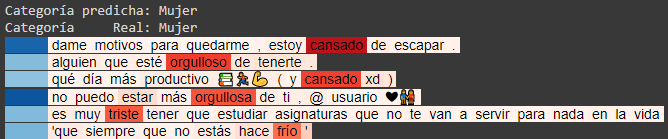

podemos ver que la red fija su atención en palabras cuya terminación puede ayudar a inferir el género, palabras como 'cansado', 'orgulloso', 'cansado' (nuevamente), 'orgullosa'. Sin embargo, la palabra 'orgulloso' en el segundo tweet o 'cansado' en el tercer tweet no hacen referencia a la persona que escribe el perfil. 

Las palabras 'cansado' (primer tweet)  y 'orgullosa'(cuarto tweet) si hacen referencia al género y la red aprende a dar mayor peso a estos tweets. Aún más sorprendete es que la red le asigna un mayor peso al cuarto tweet que al primero y esto probablemente permite clasificar de manera correcta el perfil. Por lo tanto parece ser el caso en que la red está entendiendo el contexto de las palabras que permiten deducir el género de una persona. 

En la siguiente imagen podemos ver que la predicción es erronea, pero aún así la atención del tweet y la palabra en la que se fija la atención son congruentes con lo que la red pudo haber observado para hacer su predicción.

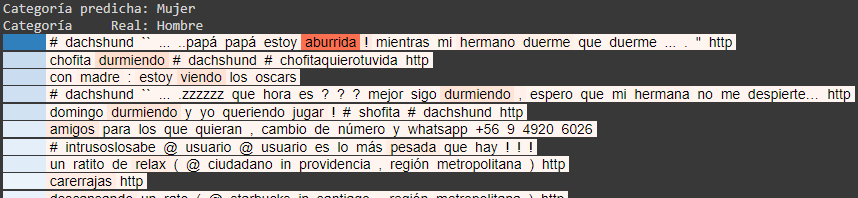

**<h2> Tabla de Resultados </h2>**

A continuación mostramos los resultados de la métrica de accuracy resumidos en una tabla para cada modelo.

**No.** | **Modelo** | **Train** | **Validation** | **Test**
 -------- |----| ---- | ---- | ----
1 |`Simple GRU` | 0.7881  | 0.5595 | 0.5600
2 | `Attention GRU` | 0.7818 | 0.7726 | 0.7550
3 | `Simple GRU Voting System` | 0.7407 | 0.7267 | 0.7086
4 | `Attention GRU Voting System` | 0.7564 | 0.7423 | 0.7221
5 | `Hierarchical GRU` | 0.9211 | 0.9060 | 0.8032


# Ejercicio 6 (Preguntas)

<h2> 6.1) ¿Le ganó a la mejor propuesta de representaciones distribucionales según lo reportado por el profesor? Si no fue así: ¿Le ganó a la Bolsa de Términos con SVM? </h2>

El modelo del profesor presenta un valor de accuracy de 0.8014 para el conjunto de **prueba** del dataset en español. La bolsa de palabras presenta un valor de 0.725 para el conjunto de **entrenamiento** del dataset en español. Con base en esta información y los resultados reportados en la sección de arriba podemos ver que los modelos 1, 2, 3 y 4 no pudieron superar a la propuesta del profesor. Tampoco pudieron superar a la bolsa de palabras, pero es importante resaltar que **los resultados reportados para la bolsa de palabras son sobre el conjunto de entrenamiento**, entonces para ser justos deberíamos comparar los valores obtenidos para la métrica en el conjunto de entrenamiento para estos modelos. Viendo la tabla de la sección de arriba podemos ver que todos los modelos **superaron** a la bolsa de palabras evaluados sobre el conjunto de entrenamiento.


Por otro lado, podemos ver a través de la tabla que el modelo con **atención jerárquica** (modelo 5) pudo superar al modelo del profesor en el conjunto de prueba del dataset en español. 

<h2> 6.2) ¿Por que cree que NO o SI le ganó? Discuta. </h2>

Los modelos de aprendizaje profundo son modelos que requieren de muchos datos para ser entrenados. La cantidad de perfiles en este caso no supera las 10000 muestras, así que es probable de que se requiera de una mayor cantidad de datos para poder obtener los beneficios que el aprendizaje profundo puede proveer para los modelos del 1 al 4. Por lo tanto considero que esta pudo ser una de las razones por la cual estos modelos no lograron superar al modelo del profesor.

En el caso del **modelo jerárquico** puede que si haya superado al modelo del profesor por la estructura "natural" de la red, es decir encondificar primero palabras y luego encondificar tweets puede ser una manera natural en la que uno podría pensar en encodificar toda la información en vez de encodifcar toda la cadena de tweets en una pasada o incluso el sistema de votación que no puede abstraer su atención a como los tweets se relacionan. Sin embargo el modelo jerárquico si puede, como vimos en la visualización de la atención está fijandose en palabras que permiten deducir el género de la persona por su terminación y además también logra ponderar bien el contexto para saber si se refiere o no a la persona misma. 

Por último recordemos que lo que los modelos de redes neuronales más complejos pueden hacer, también lo puede hacer un perceptrón multicapa, pero la cantidad de datos que requieren es inmensa, por lo tanto tener arquitecturas que se adaptan más al contexto del problema puede beneficiar esta ausencia de datos.

<h2>  6.3) ¿Qué usó el primer lugar de la competencia? (Basile, et al.) </h2>

Utilizaron una SVM (Máquina de Soporte Vectorial) que utiliza N-Gramas, uno a nivel de caracteres de 3 a 5 caracteres y otro a nivel de palabras de 1 a 2 palabras. 

<h2> 6.4) ¿Cuántos y que competidores usaron deep learning? En una o dos oraciones escriba qué hicieron. </h2>

5 competidores utilizaron deep learning, a continuación describimos brevemente que hizo cada competidor.

**<h3> Yasuhide Miura et al. Author Profiling with
Word+Character Neural Attention Network.</h3>** 

Los autores de este trabajo crearon dos modelos, similares en algunas características. Para el primer modelo utilizan embeddings a nivel de palabras y a nivel de caracteres, y luego los embeddings de palabras los procesan con una RNN con atención y los embeddings de caracteres los procesan con una CNN, ambas salidas son concatenadas y pasan a través de otra CNN y otra capa de atención para finalmente pasar a través de dos capas fully connected.  

 El segundo modelo es parecido, solo que la RNN tiene dos capas de atención (de manera jerárquica) en donde la última obtiene la información codificada por palabras y conforman una representación de un tweet, y luego estos tweets pasan por una capa de atención.  Por otro lado la convolucional tiene su propia capa de atención también a nivel de tweets pero codificando la información a nivel de caracteres. Finalmente estas salidas (RNN y CNN) se concatenan y pasan igual por dos capas fully connected.   

**<h3> Sebastian Sierra et al. Convolutional Neural Networks for Author Profiling</h3>**

Utilizan N-gramas, obtienen los embeddings de las palabras del N-Grama y estos embeddings pasan a través de una capa convolucional. Finalmente se utiliza una función de activación softmax para obtener la clasificación.

**<h3>  Franco-Salvador et al. Deep Averaging Networks </h3>**

Utilizan un N-Grama y obtienen los embeddings de las palabras, luego esta información pasa por una capa para promediar los embeddings y esta salida pasa a traves de varias capas ocultas no lineales y finalmente por una capa de softmax para obtener la clasificación.

**<h3> Nils Schaetti. TF-IDF and Deep-Learning for
Author Profiling </h3>**

Utilizan 2-Gramas a nivel de caracteres para obtener una representación y formar una matriz. Esta matriz se pasa a través de una CNN y se utiliza una capa de softmax para obtener la clasificación. 

**<h3> Kodiyan et al. Author Profiling with Bidirectional RNNs using
Attention with GRUs </h3>**

Esta solución es muy parecida a alguno de los incisos, obtienen los embeddings de las palabras y estas pasan por una RNN (una GRU de hecho) bidireccional y luego se tiene una capa de atención. Finalmente la clasificación se hace con una capa Softmax. 